In [1]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import pyarrow as pa
import os

import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from mpl_toolkits.mplot3d import Axes3D

import sklearn.metrics as sm
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from datetime import datetime


import seaborn as sns
import math

In [2]:
sg = pq.read_table('city=Singapore/'+'part-00000-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet')
sg = sg.to_pandas()
sg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3034553 entries, 0 to 3034552
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   trj_id         object 
 1   driving_mode   object 
 2   osname         object 
 3   pingtimestamp  int64  
 4   rawlat         float64
 5   rawlng         float64
 6   speed          float64
 7   bearing        int64  
 8   accuracy       float64
dtypes: float64(4), int64(2), object(3)
memory usage: 208.4+ MB


In [3]:
sg.head()

,trj_id,driving_mode,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy
0,70014,car,android,1554943236,1.342326,103.888969,18.910000,248,3.9
1,73573,car,android,1555582623,1.321781,103.856366,17.719076,44,4.0
2,75567,car,android,1555141026,1.327088,103.861273,14.021548,34,3.9
3,1410,car,android,1555731693,1.262482,103.823794,13.026521,181,4.0
4,4354,car,android,1555584497,1.283799,103.807210,14.812943,93,3.9


In [4]:
#pd.concat(g for _, g in df.groupby("ID") if len(g) > 1)

flag = 0
for g in sg.groupby("trj_id"):
    # g[0] == trjID, g[1] is datafram
    
    if len(g) > 1:
        if flag == 0:
            tempData = g[1]
            max = tempData.loc[tempData['pingtimestamp'].idxmax()]
            max = max.to_frame()
            max = max.transpose()
            min = tempData.loc[tempData['pingtimestamp'].idxmin()]
            min = min.to_frame()
            min = min.transpose()
            flag = 1
            
        else:
            tempData = g[1]
            max = max.append(tempData.loc[tempData['pingtimestamp'].idxmax()])
            min = min.append(tempData.loc[tempData['pingtimestamp'].idxmin()])

In [5]:
end = max
start = min
end.dropna(inplace = True)
start.dropna(inplace = True)


def unixToHour(string_):
    string_ = int(string_)
    return int(datetime.utcfromtimestamp(string_).strftime("%H"))+int(datetime.utcfromtimestamp(string_).strftime("%M"))/60

end["pingtimestamp"] = end["pingtimestamp"].apply(unixToHour)
start["pingtimestamp"] = start["pingtimestamp"].apply(unixToHour)

In [6]:
def cosTime(int_):
    return math.cos((int_/12) * math.pi)

def sinTime(int_):
    return math.sin((int_/12) * math.pi)

In [7]:
start['cosTime'] = start["pingtimestamp"].apply(cosTime)
start['sinTime'] = start["pingtimestamp"].apply(sinTime)

end['cosTime'] = end["pingtimestamp"].apply(cosTime)
end['sinTime'] = end["pingtimestamp"].apply(sinTime)

In [8]:
start.head()

,trj_id,driving_mode,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,cosTime,sinTime
329054,10,car,android,11.416667,1.30158,103.799,4.54325,133,6,-0.988362,0.152123
268082,100,car,ios,2.733333,1.34411,103.938,13.1025,202,13,0.754710,0.656059
2993050,1000,car,ios,0.816667,1.43452,103.788,12.0939,191,6,0.977231,0.212178
238970,10001,car,android,11.933333,1.37509,103.833,3.74578,203,3.585,-0.999848,0.017452
1889681,10004,car,ios,3.200000,1.43335,103.769,20.6965,175,8,0.669131,0.743145


In [9]:
X = start[["rawlng", "rawlat", "sinTime", "cosTime"]]

# no of constituencies = 31, approx timeframe = 3, supposed k == 93
max_k = 20

In [10]:
distortions = [] 
for i in range(5, max_k+1):
    if len(X) >= i:
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        pipe = make_pipeline(StandardScaler(), kmeans)
        pipe.fit(X)
        distortions.append(pipe[-1].inertia_)


In [11]:
k = [i*100 for i in np.diff(distortions,2)]
m = 1000000
for n in k:
    if n<m:
        m=n
idxV=m

print(k.index(idxV))
k=k.index(idxV)


kmeans = KMeans(n_clusters = k, init="k-means++")
kmeans = make_pipeline(StandardScaler(), kmeans)
kmeans = kmeans.fit(X)
kmeans = kmeans[-1]

10


In [12]:
kmeans.cluster_centers_

array([[-0.39614379,  1.36325593, -0.61404434,  1.30024618],
       [-0.43977065,  1.41252811, -0.79611648, -0.99900588],
       [ 1.00338489, -0.06184098,  0.11613551,  1.22533995],
       [ 0.03410993, -1.01807641,  0.8314447 , -0.39225613],
       [-1.37001189, -0.12715608,  0.69193694, -0.54194882],
       [ 1.2804493 , -0.00417531,  0.62460256, -0.69819703],
       [-0.21150136, -0.90076551, -1.20391704, -0.85348165],
       [-0.37029361,  1.47986916,  0.99208506,  0.15172596],
       [-0.85317013, -0.51237548, -0.09278914,  1.26638957],
       [ 1.40471722, -0.03567488, -1.47202421, -0.68445973]])

In [13]:
start['Clusters'] = kmeans.labels_
start.head()

,trj_id,driving_mode,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,cosTime,sinTime,Clusters
329054,10,car,android,11.416667,1.30158,103.799,4.54325,133,6,-0.988362,0.152123,6
268082,100,car,ios,2.733333,1.34411,103.938,13.1025,202,13,0.754710,0.656059,2
2993050,1000,car,ios,0.816667,1.43452,103.788,12.0939,191,6,0.977231,0.212178,0
238970,10001,car,android,11.933333,1.37509,103.833,3.74578,203,3.585,-0.999848,0.017452,1
1889681,10004,car,ios,3.200000,1.43335,103.769,20.6965,175,8,0.669131,0.743145,7


<IPython.core.display.Javascript object>


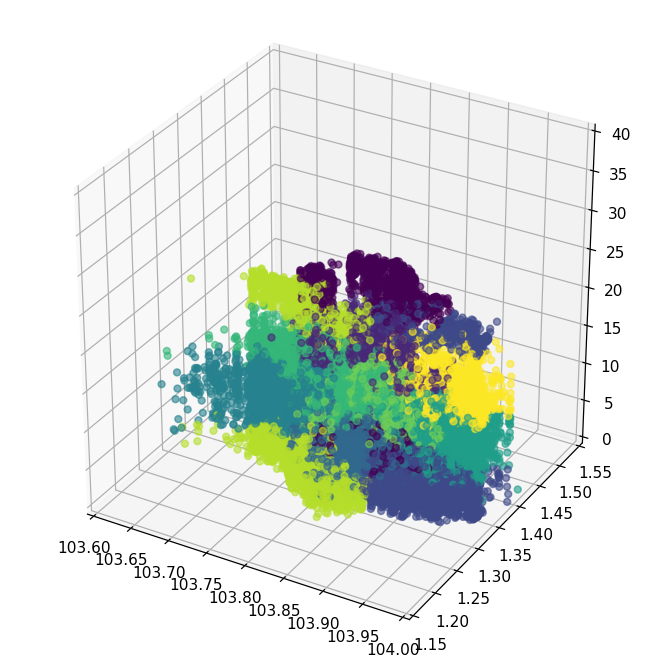

<ipython-input-14-f034b7c14838>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_axes(ax)


In [14]:
#3d
%matplotlib notebook
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
fig.add_axes(ax)

# axis equal
ax.set_xlim3d(103.6, 104)
ax.set_ylim3d(1.15, 1.55)
ax.set_zlim3d(0, 40)


sc = ax.scatter(start[["rawlng"]], start[["rawlat"]], start[["pingtimestamp"]], c=start[["Clusters"]], cmap='viridis', alpha=0.6)

In [71]:
df = pd.read_csv('trip_info.csv')

In [75]:
new = start[["Clusters"]]

In [76]:
result = df
result["cls_TvL"] = new.iloc[:,0].values

In [77]:
result.head(11)

,Unnamed: 0,trj_id,start_time,end_time,ETA,start_lat,end_lat,start_lng,end_lng,distance,cls_TvL
0,0,10,2019-04-09 11:25:54,2019-04-09 11:44:54,0 days 00:19:00,1.301581,1.358010,103.799431,103.845159,9.875596,6
1,1,100,2019-04-16 02:44:24,2019-04-16 03:00:37,0 days 00:16:13,1.344114,1.335289,103.938375,103.843102,12.813825,2
2,2,1000,2019-04-11 00:49:45,2019-04-11 01:03:22,0 days 00:13:37,1.434515,1.370538,103.788474,103.860748,13.478591,0
3,3,10001,2019-04-17 11:56:50,2019-04-17 12:17:05,0 days 00:20:15,1.375087,1.328267,103.833377,103.750637,16.901128,1
4,4,10004,2019-04-09 03:12:39,2019-04-09 03:26:37,0 days 00:13:58,1.433348,1.393925,103.768741,103.907360,18.371995,7
5,5,10005,2019-04-17 01:21:53,2019-04-17 01:38:39,0 days 00:16:46,1.371171,1.301499,103.871349,103.843059,10.058410,2
6,6,1001,2019-04-13 12:13:33,2019-04-13 12:30:10,0 days 00:16:37,1.341931,1.330077,103.733847,103.875341,18.040398,4
7,7,10010,2019-04-21 04:49:21,2019-04-21 05:28:25,0 days 00:39:04,1.325336,1.407428,103.726036,103.895450,36.526935,4
8,8,10011,2019-04-20 08:07:06,2019-04-20 08:41:19,0 days 00:34:13,1.322075,1.375473,103.703444,103.959461,41.190592,4
9,9,10013,2019-04-08 21:22:49,2019-04-08 21:41:29,0 days 00:18:40,1.363109,1.348167,103.842660,103.699218,20.705525,0


In [80]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  28000 non-null  int64  
 1   trj_id      28000 non-null  int64  
 2   start_time  28000 non-null  object 
 3   end_time    28000 non-null  object 
 4   ETA         28000 non-null  object 
 5   start_lat   28000 non-null  float64
 6   end_lat     28000 non-null  float64
 7   start_lng   28000 non-null  float64
 8   end_lng     28000 non-null  float64
 9   distance    28000 non-null  float64
 10  cls_TvL     28000 non-null  int32  
dtypes: float64(5), int32(1), int64(2), object(3)
memory usage: 2.2+ MB


In [78]:
df.to_parquet('trip_info.parquet')